In [1]:
import cv2
import datetime
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
# We can use pandas to read the text file and take a initial look at what we have
poses = pd.read_csv('C://Users//Bhaven//Downloads//Robotics//KITTI_visual_odometry//dataset//poses//02.txt', delimiter=' ', header=None)
print('Shape of position dataframe:', poses.shape)
poses.head()

Shape of position dataframe: (4661, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043683e-12,2.326809e-11,1.110223e-16,9.043683e-12,1.000000,2.392370e-10,3.330669e-16,2.326810e-11,2.392370e-10,1.000000,-2.220446e-16
1,0.999997,-2.220141e-03,-1.303943e-03,5.542524e-03,2.223603e-03,0.999994,2.659561e-03,-3.047694e-02,1.298030e-03,-2.662451e-03,0.999996,1.528975e+00
2,0.999992,-3.006968e-03,-2.825820e-03,5.664279e-03,3.016952e-03,0.999989,3.535540e-03,-6.012991e-02,2.815159e-03,-3.544035e-03,0.999990,3.052409e+00
3,0.999989,-2.128535e-03,-4.205819e-03,3.267206e-03,2.141750e-03,0.999993,3.139851e-03,-8.838230e-02,4.199105e-03,-3.148823e-03,0.999986,4.566315e+00
4,0.999983,-1.524541e-03,-5.643893e-03,-6.648871e-03,1.542552e-03,0.999994,3.188330e-03,-1.107150e-01,5.638997e-03,-3.196981e-03,0.999979,6.079413e+00


In [3]:
# We can see that we have 4541 rows and 12 columns. 4541 is the number of image frames in this
# sequence, and the number 12 comes from flattening a 3x4 transformation matrix of the left
# stereo camera with respect to the global coordinate frame. The global frame is established 
# the coordinate frame of the camera's first position. A 3x4 transfomration matrix contains
# a 3x3 rotation matrix horizontally stacked with a 3x1 translation vector in the form R|t
# To verify this, we can look at the first pose, and see that the
# rotational component is identity, with a translation vector equal to zero for all axes.
print('First position:')
first_pose = np.array(poses.iloc[0]).reshape((3,4)).round(2)
first_pose

First position:


array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.]])

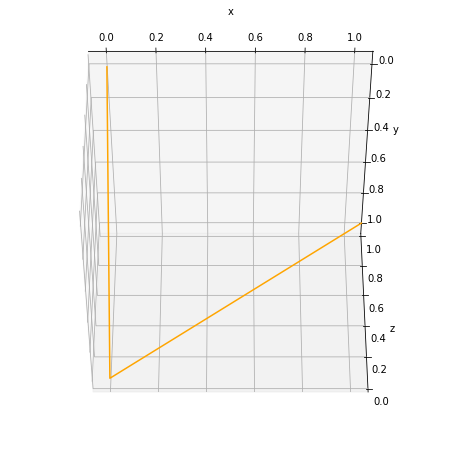

In [4]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(first_pose[:, 0], 
        first_pose[:, 1], 
        first_pose[:, 2], label='estimated', color='orange')

# ax.plot(handler.gt[:, :, 3][:, 0], 
#         handler.gt[:, :, 3][:, 1], 
#         handler.gt[:, :, 3][:, 2], label='ground truth')
# ax.set_xlim3d(-5, 5)
# ax.set_ylim3d(-5, 5)
# ax.set_zlim3d(-5, 5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-40, azim=270)

In [5]:
# To establish this logic, we can do a quick sanity check on the math.
# First, let's store all of these ground truth (gt) position matrices into a numpy array with 
# the proper shape for convenient access:
gt = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
print(gt.size)
print(gt)

55932
[[[ 1.000000e+00  9.043683e-12  2.326809e-11  1.110223e-16]
  [ 9.043683e-12  1.000000e+00  2.392370e-10  3.330669e-16]
  [ 2.326810e-11  2.392370e-10  9.999999e-01 -2.220446e-16]]

 [[ 9.999967e-01 -2.220141e-03 -1.303943e-03  5.542524e-03]
  [ 2.223603e-03  9.999940e-01  2.659561e-03 -3.047694e-02]
  [ 1.298030e-03 -2.662451e-03  9.999956e-01  1.528975e+00]]

 [[ 9.999915e-01 -3.006968e-03 -2.825820e-03  5.664279e-03]
  [ 3.016952e-03  9.999892e-01  3.535540e-03 -6.012991e-02]
  [ 2.815159e-03 -3.544035e-03  9.999897e-01  3.052409e+00]]

 ...

 [[ 6.759954e-01  2.789004e-02 -7.363779e-01  1.234262e+02]
  [ 4.118290e-02  9.962919e-01  7.554012e-02 -2.076716e+01]
  [ 7.357542e-01 -8.139093e-02  6.723401e-01  9.144012e+02]]

 [[ 6.784164e-01  2.585583e-02 -7.342225e-01  1.224460e+02]
  [ 5.179065e-02  9.952111e-01  8.290080e-02 -2.070084e+01]
  [ 7.328498e-01 -9.426710e-02  6.738284e-01  9.153117e+02]]

 [[ 6.808971e-01  2.896301e-02 -7.318062e-01  1.214574e+02]
  [ 5.181616e-02  

In [6]:
# If we take the transformation matrix from the second frame and take the dot product with
# the camera's origin in its own coordinate frame for that frame (the origin of the camera
# in its own reference frame is always [0,0,0,1] for any frame), we can see where
# the camera is in relation to the global coordinate frame, which is the coordinate frame
# of the camera's first position. Notice that we are using homogeneous coordinates, in that
# we have added a 1 to the end of a vector in 3D space. This makes the application of the 
# rotational and translational components of the transformation convenient in one multiplication
# step. This trick will continue to come in handy later.
gt[1].dot(np.array([0,0,0,1]))

array([ 0.00554252, -0.03047694,  1.528975  ])

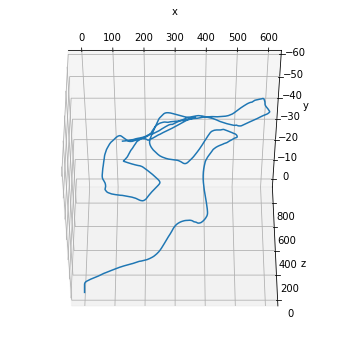

In [7]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

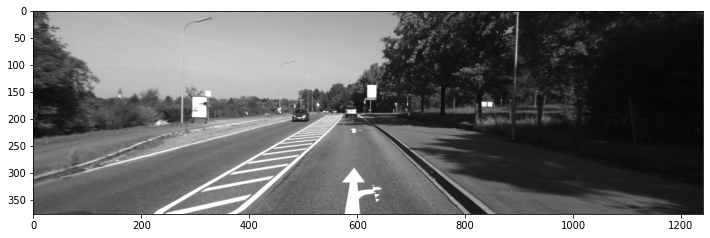

In [8]:
test_img = cv2.imread('C://Users//Bhaven//Downloads//Robotics//KITTI_visual_odometry//dataset/sequences/02/image_0/000000.png')
plt.figure(figsize=(12,6))
plt.imshow(test_img)
plt.savefig("og.png")

In [9]:
# We can see that the timing of the camera is right around 10fps
times = pd.read_csv('C://Users//Bhaven//Downloads//Robotics//KITTI_visual_odometry//dataset/sequences/02/times.txt', delimiter=' ', header=None)
times.head()

,0
0,0.000000
1,0.103612
2,0.207353
3,0.311118
4,0.414713


In [10]:
# We can load in our sensor calibration data as follows
calib = pd.read_csv('C://Users//Bhaven//Downloads//Robotics//KITTI_visual_odometry//dataset/sequences/02/calib.txt', delimiter=' ', header=None, index_col=0)
calib

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


In [11]:
# P0 is the projection matrix left grayscale camera
P0 = np.array(calib.loc['P0:']).reshape((3,4))
P0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

In [12]:
# Decomposing a projection matrix with OpenCV
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix:')
print(k1)
print('Rotation Matrix:')
print(r1)
print('Translation Vector:')
print(t1.round(4))

Intrinsic Matrix:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


In [13]:
# Above, we can see the intrinsic matrix k, the rotation matrix R, and the translation vector
# t we got by decomposing the projection matrix given for the right camera. Remember that
# the extrinsic matrix is actually a horizontal stack of R and t in the form (R|t), which
# we can use to transform a 3D homogenous coordinate in the global frame to a 3D coordinate
# in the camera frame, at least if this were a normal camera projection matrix.
# In this case, let's see what we get if we transform the origin of the global coordinate
# frame (the origin of the left grayscale camera) using the tranformation/extrinsic matrix
# we got from this projection matrix. According to the schematic, we should expect it to be
# 0.54m to the left (X = -0.54)
# Note that the OpenCV function has provided t as a homogeneous coordinate, so we need to
# drop the fourth value to horizontally stack it with the 3x3 rotation matrix.
Rt = np.hstack([r1, t1[:3]])
# Now to consider transform the origin of the global frame (0, 0, 0, 1)
origin = np.array([0, 0, 0, 1])
Rt.dot(origin).round(4).reshape(-1,1)

array([[ 0.5372],
       [ 0.    ],
       [-0.    ]])

In [14]:
# As an exercise, let's turn this rectified projection matrix into a regular projection matrix
# for the right grayscale camera. We do this by decomposing the matrix, making the extrinsic
# matrix homogeneous, inverting it, then recombining the intrinsic and inverted extrinsic.
# Since we've already decomposed and stacked the Rt transformation matrix, let's now make
# it homogeneous and run our test to see if the origin of the left camera appears at X=-0.54
T_homogeneous = np.vstack([Rt, np.array([0, 0, 0, 1])])
T_hom_inv = np.linalg.inv(T_homogeneous)
print('Homogeneous transformation matrix:')
print(T_homogeneous.round(4))
print('Inverted homogeneous transformation matrix:')
print(T_hom_inv.round(4))

Homogeneous transformation matrix:
[[ 1.      0.      0.      0.5372]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.     -0.    ]
 [ 0.      0.      0.      1.    ]]
Inverted homogeneous transformation matrix:
[[ 1.      0.      0.     -0.5372]
 [ 0.      1.      0.     -0.    ]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.      0.      1.    ]]


In [15]:
# Let's take some point measured with respect to the coordinate frame of the left camera when 
# it is in it's 14 pose of the sequence, and transform it onto the image plane of the camera
# in it's first position, which we can do by using accessing the 14th pose from the ground truth
# Here are the coordinates of the point measured in this frame
some_point = np.array([1, 2, 3, 1]).reshape(-1,1)
# Let's get the depth of this point from the left camera by tranforming it into the coordinate
# frame of the left camera, and taking the Z value. We can do the transformation using the
# Rt matrix we stacked a moment ago.
transformed_point = gt[14].dot(some_point)
depth_from_cam = transformed_point[2]

print('Original point:\n', some_point)
print('Transformed point:\n', transformed_point.round(4))
print('Depth from camera:\n', depth_from_cam.round(4))

Original point:
 [[1]
 [2]
 [3]
 [1]]
Transformed point:
 [[ 0.7131]
 [ 1.703 ]
 [23.9945]]
Depth from camera:
 [23.9945]


In [16]:
# The next two matrices are referring to the RGB cameras. In that case we won't
# need them, but let's see if this makes sense
P2 = np.array(calib.loc['P2:']).reshape((3,4))
k2, r2, t2, _, _, _, _ = cv2.decomposeProjectionMatrix(P2)
t2 = t2 / t2[3]
print(k2)
print(r2)
print(t2)

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-0.05993858]
 [ 0.00113119]
 [-0.00377976]
 [ 1.        ]]


In [17]:
# We can see that this camera is just slightly to the left of the main camera.
# Let's now repeat this process for the fourth P matrix and see what we see
P3 = np.array(calib.loc['P3:']).reshape((3,4))
k3, r3, t3, _, _, _, _ = cv2.decomposeProjectionMatrix(P3)
t3 = t3 / t3[3]
print(k3)
print(r3)
print(t3)

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.47335236]
 [-0.00202917]
 [-0.00491521]
 [ 1.        ]]


In [18]:
class Dataset_Handler():
    def __init__(self, sequence, progress_bar=True, low_memory=True):
        
        # This will tell odometry functin how to access data from this object
        self.low_memory = low_memory
        
        # Set file paths and get ground truth poses
        self.seq_dir = 'C://Users//Bhaven//Downloads//Robotics//KITTI_visual_odometry//dataset/sequences/{}/'.format(sequence)
        self.poses_dir = 'C://Users//Bhaven//Downloads//Robotics//KITTI_visual_odometry//dataset/poses/{}.txt'.format(sequence)
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        # Get names of files to iterate through
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.num_frames = len(self.left_image_files)
        
        # Get calibration details for scene
        # P0 and P1 are Grayscale cams, P2 and P3 are RGB cams
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        # This is the transformation matrix for LIDAR
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        # Get times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', 
                                          delimiter=' ', 
                                          header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        # Get images and lidar loaded
        if self.low_memory:
            # Will use generators to provide data sequentially to save RAM
            # Use class method to set up generators
            self.reset_frames()
            # Store original frame to memory for testing functions
            self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[0], 0)
            self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                               + self.right_image_files[0], 0)
            self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[1], 0)
           
            self.imheight = self.first_image_left.shape[0]
            self.imwidth = self.first_image_left.shape[1]
            
        else:
            # If RAM is not a concern (>32GB), pass low_memory=False
            if progress_bar:
                import progressbar
                bar = progressbar.ProgressBar(max_value=self.num_frames)
            self.images_left = []
            self.images_right = []
            self.pointclouds = []
            for i, name_left in enumerate(self.left_image_files):
                name_right = self.right_image_files[i]
                self.images_left.append(cv2.imread(self.seq_dir + 'image_0/' + name_left))
                self.images_right.append(cv2.imread(self.seq_dir + 'image_1/' + name_right))
                if progress_bar:
                    bar.update(i+1)
                
            self.imheight = self.images_left[0].shape[0]
            self.imwidth = self.images_left[0].shape[1]
            # Keep consistent instance variable names as when using low_memory
            self.first_image_left = self.images_left[0]
            self.first_image_right = self.images_right[0]
            self.second_image_left = self.images_left[1]
        
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        pass

In [19]:
# Creating a handler object for low_memory (<32GB) setups:
handler = Dataset_Handler('02')

In [20]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    '''
    Takes a left and right stereo pair of images and computes the disparity map for the left
    image. Pass rgb=True if the images are RGB.
    
    Arguments:
    img_left -- image from left camera
    img_right -- image from right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM matching
    rgb -- (bool) set to True if passing RGB images as input
    verbose -- (bool) set to True to report matching type and time to compute
    
    Returns:
    disp_left -- disparity map for the left camera image
    
    '''
    # Feel free to read OpenCV documentation and tweak these values. These work well
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

Time to compute disparity map using StereoBM: 0:00:00.024936
<class 'numpy.ndarray'>


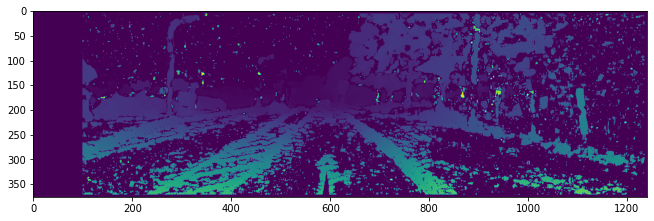

In [21]:
# Compute disparity using StereoBM
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);
plt.savefig("disparity.png")
print(type(disp))

In [ ]:
import pygame
pygame.init()
display = pygame.display.set_mode((800, 600))

exit = False

while not exit:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            exit = True
        print(event)
        if event.type == pygame.KEYDOWN:
            surf = pygame.surfarray.make_surface(disp)
            display.blit(surf, (0, 0))

    pygame.display.update()

pygame.quit()
quit()

You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable
pygame 2.1.2 (SDL 2.0.18, Python 3.9.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
<Event(4352-AudioDeviceAdded {'which': 0, 'iscapture': 0})>
<Event(4352-AudioDeviceAdded {'which': 1, 'iscapture': 0})>
<Event(4352-AudioDeviceAdded {'which': 2, 'iscapture': 0})>
<Event(4352-AudioDeviceAdded {'which': 0, 'iscapture': 1})>
<Event(4352-AudioDeviceAdded {'which': 1, 'iscapture': 1})>
<Event(32768-ActiveEvent {})>
<Event(32774-WindowShown {'window': None})>
<Event(32770-VideoExpose {})>
<Event(32776-WindowExposed {'window': None})>
<Event(32768-ActiveEvent {'gain': 1, 'state': 1})>
<Event(32785-WindowFocusGained {'window': None})>
<Event(770-TextEditing {'text': '', 'start': 0, 'length': 0, 'window': None})>
<Event(32770-VideoExpose {})>
<Event(32776-WindowExposed {'window': None})>
<Event(32768-ActiveEvent {'gain': 1, 'state': 0})>
<Event(32783-WindowEnter {'window': None})>
<Event(10

In [22]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

In [23]:
#Depth Map
def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [24]:
k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler.P1)

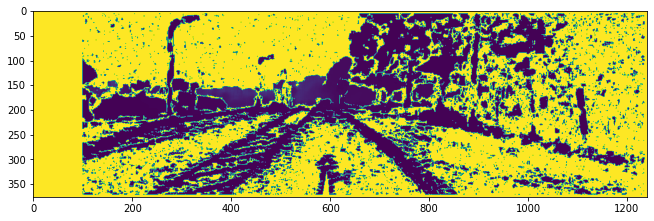

In [25]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.imshow(depth);

In [26]:
# Knowing the focal length and baseline, we can see that these max values are the result of
# wherever we had -1.0 or 0 disparity, which we turned to 0.1 in the depth map function to
# avoid instability or division by zero, shown below:
k_left[0][0] * (t_right[0] - t_left[0]) / 0.1

array([3861.448])

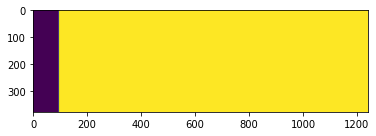

In [27]:
# We can constuct a mask using this information like so
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);

In [28]:
# Let's make an all-inclusive function to get the depth from an incoming set of stereo images
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):
    '''
    Takes stereo pair of images and returns a depth map for the left camera. If your projection
    matrices are not rectified, set rectified=False.
    
    Arguments:
    img_left -- image of left camera
    img_right -- image of right camera
    P0 -- Projection matrix for the left camera
    P1 -- Projection matrix for the right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM
    rgb -- (bool) set to True if images passed are RGB. Default is False
    verbose -- (bool) set to True to report computation time and method
    rectified -- (bool) set to False if P1 not rectified to P0. Default is True
    
    Returns:
    depth -- depth map for left camera
    
    '''
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

In [29]:
def extract_features(image, detector='sift', mask=None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [30]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [31]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [32]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

Time to compute disparity map using StereoBM: 0:00:00.019050
Number of matches before filtering: 1684
Number of matches after filtering: 179


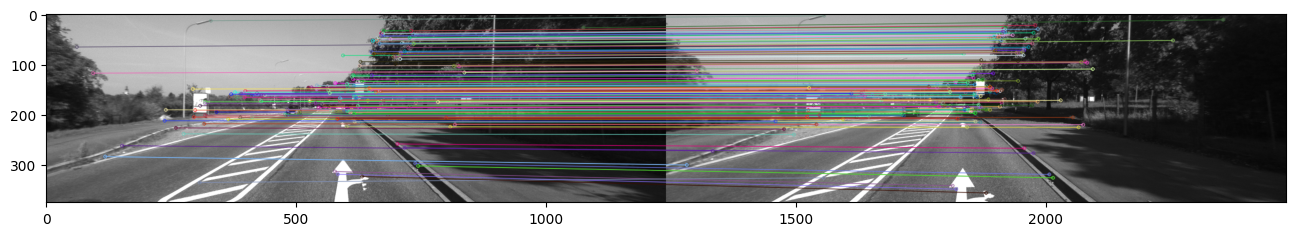

In [33]:
# Now to see the difference with 'bm' matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)
plt.savefig("feature.png")

In [34]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera intrinsic calibration matrix 
    
    Optional arguments:
    depth1 -- Depth map of the first frame. Set to None to use Essential Matrix decomposition
    max_depth -- Threshold of depth to ignore matched features. 3000 is default

    Returns:
    rmat -- estimated 3x3 rotation matrix
    tvec -- estimated 3x1 translation vector
    image1_points -- matched feature pixel coordinates in the first image. 
                     image1_points[i] = [u, v] -> pixel coordinates of i-th match
    image2_points -- matched feature pixel coordinates in the second image. 
                     image2_points[i] = [u, v] -> pixel coordinates of i-th match
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            # If the depth at the position of our matched feature is above 3000, then we
            # ignore this feature because we don't actually know the depth and it will throw
            # our calculations off. We add its index to a list of coordinates to delete from our
            # keypoint lists, and continue the loop. After the loop, we remove these indices
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

In [35]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    plot=False):
    '''
    Function to perform visual odometry on a sequence from the KITTI visual odometry dataset.
    Takes as input a Data_Handler object and optional parameters.
    
    Arguments:
    handler -- Data_Handler object instance
    
    Optional Arguments:
    detector -- (str) can be 'sift' or 'orb'. Default is 'sift'.
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'. Default is 'BF'.
    filter_match_distance -- (float) value for ratio test on matched features. Default is None.
    stereo_matcher -- (str) can be 'bm' (faster) or 'sgbm' (more accurate). Default is 'bm'.
    mask -- (array) mask to reduce feature search area to where depth information available.
    depth_type -- (str) can be 'stereo' or set to None to use Essential matrix decomposition.
                        Note that scale will be incorrect with no depth used.
    subset -- (int) number of frames to compute. Defaults to None to compute all frames.
    plot -- (bool) whether to plot the estimated vs ground truth trajectory. Only works if
                   matplotlib is set to tk mode. Default is False.
    
    Returns:
    trajectory -- Array of shape Nx3x4 of estimated poses of vehicle for each computed frame.
    
    '''
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
  
    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
        # Set num_frames to one less than the number of frames so we have sequential images
        # in the last frame run.
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    # Establish homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)
    
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        # Stop if we've reached the second to last frame, since we need two sequential frames
        #if i == num_frames - 1:
        #    break
        # Start timer for frame
        start = datetime.datetime.now()
        # Get our stereo images for depth estimation
        if handler.low_memory:
            image_left = image_plus1
            image_right = next(handler.images_right)
            # Get next frame in the left camera for visual odometry
            image_plus1 = next(handler.images_left)
        else:
            image_left = handler.images_left[i]
            image_right = handler.images_right[i]
            # Get next frame in the left camera for visual odometry
            image_plus1 = handler.images_left[i+1]
        
        # Estimate depth if using stereo depth estimation (recommended)
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
        # Otherwise use Essential Matrix decomposition (ambiguous scale)
        else:
            depth = None
            
        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in the two images
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)
        
        # The following code is commented out because it is only necessary if you intend to
        # use very low distance ratios for match filtering. Feel free to uncomment and try
        # out using very low distance ratios, but if you do, comment out the above line.
        # Try to get motion with filter distance, if not increase threshold until success
        #try:
        #    rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                           kp0, 
        #                                                           kp1, 
        #                                                           k_left, 
        #                                                           depth)
        #except:
        #    filt_inc = 0.1
        #    while True:
        #        print('Not enough features after filter with threshold {},'.format(filter_match_distance),
        #              'raising threshold to {} until next frame.'.format(filter_match_distance + filt_inc)) 
        #        try:
        #            matches = filter_matches_distance(matches_unfilt, filter_match_distance+filt_inc)
        #            rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                                   kp0, 
        #                                                                   kp1, 
        #                                                                   k_left, 
        #                                                                   depth)
        #            break
        #        except:
        #            filt_inc += 0.1
        #            continue
                  
        # Create blank homogeneous transformation matrix
        Tmat = np.eye(4)
        # Place resulting rotation matrix  and translation vector in their proper locations
        # in homogeneous T matrix
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        # The SolvePnPRansac() function computes a pose that relates points in the global
        # coordinate frame to the camera's pose. We used the camera's pose in the first image
        # as the global coordinate frame, reconstruct 3D positions of the features in the
        # image using stereo depth estimation, then find a pose which relates the camera in
        # the next frame to those 3D points. When tracking the vehicle pose over time, what we
        # actually want is to relate the points in the camera's coordinate frame to the global
        # frame, so we want the opposite (inverse) of the transformation matrix provided to us
        # by the SolvePnPRansac function. Recall from the earlier discussion that we can find
        # the inverse of a transformation matrix by making it homogeneous by adding a row of
        # (0, 0, 0, 1) to it, then taking its inverse. Further, we are tracking the vehicle
        # motion from the very first camera pose, so we need the cumulative product of the
        # inverses of each estimated camera pose given to us by SolvePnPRansac. Thus, below
        # we iteratively multiply the T_tot homogeneous transformation matrix that we 
        # instantiated before the for loop by the inverse of each successive pose we estimate,
        # and save its current values into our estimated poses at an index corresponding to our
        # current frame. This way, the transformation matrix at each index will be one that
        # relates 3D homogeneous coordinates in the camera's frame to the global coordinate
        # frame, which is the coordinate frame of the camera's first position. The translation
        # vector component of this transformation matrix will describe where the camera's curent
        # origin is in this global referece frame.
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
        plt.close()
        
    return trajectory

In [36]:
# We need a function to tell us how much error we have compared to the ground truth
# We will use Euclidean distance of each camera pose from the ground truth to give us
# Mean Squared Error (mse), Root Mean Squared Error (rmse), or Mean Absolute Error (mae)
def calculate_error(ground_truth, estimated, error_type='mse'):
    '''
    Takes arrays of ground truth and estimated poses of shape Nx3x4, and computes error using
    Euclidean distance between true and estimated 3D coordinate at each position.
    
    Arguments:
    ground_truth -- Nx3x4 array of ground truth poses
    estimated -- Nx3x4 array of estimated poses
    
    Optional Arguments:
    error_type -- (str) can be 'mae', 'mse', 'rmse', or 'all' to return dictionary of all 3
    
    Returns:
    error -- either a float or dictionary of error types and float values
    
    '''
    # Find the number of frames in the estimated trajectory to compare with
    nframes_est = estimated.shape[0]
    
    def get_mse(ground_truth, estimated):
        se = np.sqrt((ground_truth[nframes_est-1, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est-1, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est-1, 2, 3] - estimated[:, 2, 3])**2)**2
        mse = se.mean()
        return mse
    
    def get_mae(ground_truth, estimated):
        ae = np.sqrt((ground_truth[nframes_est-1, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est-1, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est-1, 2, 3] - estimated[:, 2, 3])**2)
        mae = ae.mean()
        return mae
    
    if error_type == 'mae':
        return get_mae(ground_truth, estimated)
    elif error_type == 'mse':
        return get_mse(ground_truth, estimated)
    elif error_type == 'rmse':
        return np.sqrt(get_mse(ground_truth, estimated))
    elif error_type == 'all':
        mae = get_mae(ground_truth, estimated)
        mse = get_mse(ground_truth, estimated)
        rmse = np.sqrt(mse)
        return {'mae': mae,
                'rmse': rmse,
                'mse': mse}

In [37]:
# See what kind of results we get without using LIDAR correction on depth
# We will use StereoBM to do depth estimate, since it is faster than StereoSGBM, then compare
handler.lidar = False
start = datetime.datetime.now()
trajectory_nolidar_bm = visual_odometry(handler,
                                        filter_match_distance=0.5, 
                                        detector='sift',
                                        matching='FLANN',
                                        stereo_matcher='bm',
                                        mask=mask,     
                                        subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with SIFT and matching with FLANN
Filtering feature matches at threshold of 0.5*distance
Time to compute frame 1: 0:00:00.258231
Time to compute frame 2: 0:00:00.251418
Time to compute frame 3: 0:00:00.258359
Time to compute frame 4: 0:00:00.255400
Time to compute frame 5: 0:00:00.262288
Time to compute frame 6: 0:00:00.258755
Time to compute frame 7: 0:00:00.253267
Time to compute frame 8: 0:00:00.249378
Time to compute frame 9: 0:00:00.250566
Time to compute frame 10: 0:00:00.257311
Time to compute frame 11: 0:00:00.321141
Time to compute frame 12: 0:00:00.290062
Time to compute frame 13: 0:00:00.292629
Time to compute frame 14: 0:00:00.294689
Time to compute frame 15: 0:00:00.276262
Time to compute frame 16: 0:00:00.258117
Time to compute frame 17: 0:00:00.262018
Time to compute frame 18: 0:00:00.259735
Time to compute frame 19: 0:00:00.267207
Time to compute frame 20: 0:00:00.276254
Time to compute frame 21: 0:00:00.264293
Tim

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_nolidar_bm[:, :, 3][:, 0], 
        trajectory_nolidar_bm[:, :, 3][:, 1], 
        trajectory_nolidar_bm[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [ ]:
calculate_error(handler.gt[:,:], trajectory_nolidar_bm, 'all')